In [5]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = FashionMNIST(root = './Pytorch_sample/data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size= 100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

26427392it [00:15, 1748451.13it/s]                              


Extracting ./Pytorch_sample/data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./Pytorch_sample/data/FashionMNIST\raw


32768it [00:00, 37147.10it/s]                           


Extracting ./Pytorch_sample/data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./Pytorch_sample/data/FashionMNIST\raw


4423680it [00:04, 1094063.03it/s]                             


Extracting ./Pytorch_sample/data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./Pytorch_sample/data/FashionMNIST\raw


8192it [00:00, 13795.71it/s]            

Extracting ./Pytorch_sample/data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./Pytorch_sample/data/FashionMNIST\raw
Processing...
Done!
cuda:0



C:\Users\bm990\.julia\conda\3\envs\DL\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid()    
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optim = optim.Adam(generator.parameters(), lr = 2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr = 2e-4)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()

In [11]:
def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))
    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item()

In [13]:
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

In [15]:
test_noise = noise(64)
l = len(trainloader)
for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0
    for data in trainloader:
        imgs,_=data
        n = len(imgs)
        fake_data = generator(noise(n)).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)
        
    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    if epoch % 10 == 0:
        print('Epoch {}: g_loss : {:.3f} d_loss : {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

Epoch 0: g_loss : 1.748 d_loss : 0.849
Epoch 10: g_loss : 1.414 d_loss : 0.949
Epoch 20: g_loss : 1.325 d_loss : 1.001
Epoch 30: g_loss : 1.248 d_loss : 1.058
Epoch 40: g_loss : 1.227 d_loss : 1.063
Epoch 50: g_loss : 1.168 d_loss : 1.100
Epoch 60: g_loss : 1.193 d_loss : 1.088
Epoch 70: g_loss : 1.112 d_loss : 1.132
Epoch 80: g_loss : 1.093 d_loss : 1.159
Epoch 90: g_loss : 1.059 d_loss : 1.183
Epoch 100: g_loss : 1.054 d_loss : 1.195
Epoch 110: g_loss : 1.022 d_loss : 1.196
Epoch 120: g_loss : 1.037 d_loss : 1.202
Epoch 130: g_loss : 1.040 d_loss : 1.191
Epoch 140: g_loss : 0.998 d_loss : 1.213
Epoch 150: g_loss : 0.996 d_loss : 1.214


In [18]:
torch.save(discriminator.state_dict(), './Pytorch_sample/models/fmnist_disc.pth')
torch.save(generator.state_dict(), './Pytorch_sample/models/fmnist_gner.pth')

to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif', imgs)

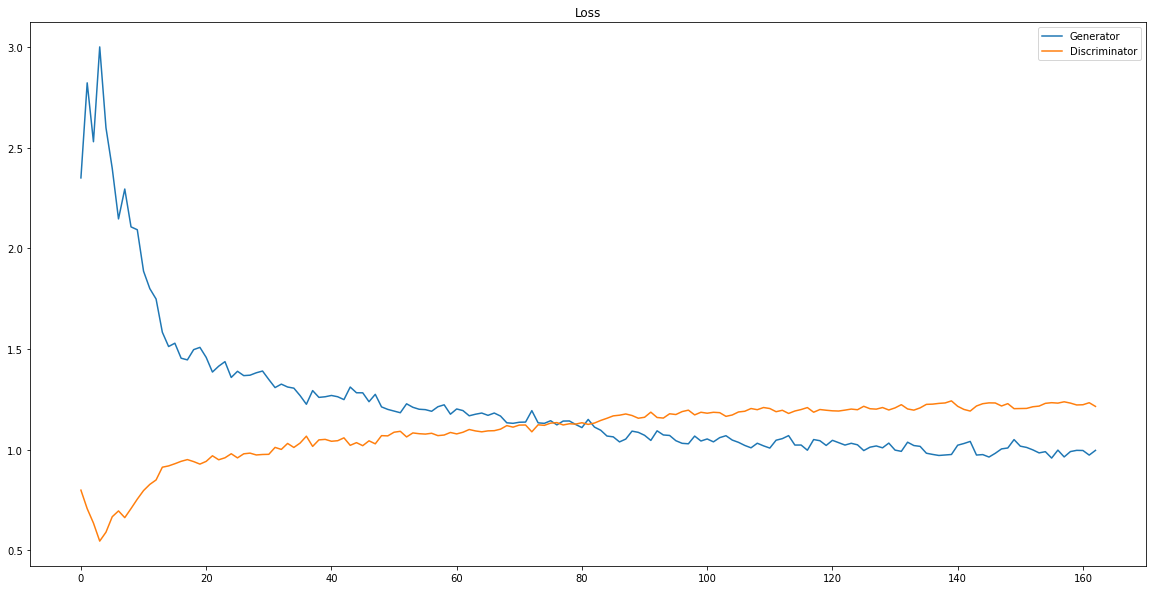

In [19]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')
plt.show()